In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pykitti
import toml

In [7]:
param = toml.load("config.toml")
basedir = param.get("basedir")
date = param.get("date")
drive = param.get("drive")
minFeatures = param.get("minFeatures")

# Load the data. Optionally, specify the frame range to load.
dataset = pykitti.raw(basedir, date, drive)
dataset_gray = list(dataset.gray)

In [4]:
class Robot:
    def __init__(self,calib_mat,minFeatures):
        self.k = calib_mat
        self.minFeatures = minFeatures 
        self.r = np.zeros([3,3])
        self.t = np.zeros([3,1])
        self.pose = np.eye(4)
        self.x_loc=[]
        self.z_loc=[]
        
        self.kp1 = []
        self.kp2 = []
        self.matches = None
        
    def process_features(self,first_frame,second_frame,calib_matrix):
        #create sift detector object
        sift = cv2.xfeatures2d.SIFT_create(edgeThreshold=10)
        
        # Extract sfit features from current and next frame
        keypoints_1, descriptors_1 = sift.detectAndCompute(first_frame,None)
        keypoints_2, descriptors_2 = sift.detectAndCompute(second_frame,None)
        
        # Filter those keypoints that are matched across frames only
        keypoints_1, keypoints_2 = self.filter_features(descriptors_1, descriptors_2, keypoints_1, keypoints_2)
        
        # Compute Essential matrix from feature list
        E, mask = cv2.findEssentialMat(keypoints_1, keypoints_2, self.k, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        
        # Compute rotation and translation matrices
        _, self.r, self.t, mask = cv2.recoverPose(E, keypoints_2, keypoints_1, self.k)
        
        return self.r, self.t
    
    def filter_features(self,descriptors_1, descriptors_2, keypoints_1, keypoints_2):
        
        #Create brute force matcher object 
        bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

        self.matches = bf.match(descriptors_1, descriptors_2)
        
        #sort matches based on distance.
        #Lower distance between descripors -> better the match
        self.matches = sorted(self.matches, key = lambda x:x.distance)

        pts1 = []
        pts2 = []
        
        idx =  self.matches[0:self.minFeatures]

        # Gtaher kepyoint objects of filtered matches from respective frames
        for i in idx:
            pts1.append(keypoints_1[i.queryIdx].pt)
            pts2.append(keypoints_2[i.trainIdx].pt)
            self.kp1.append(keypoints_1[i.queryIdx])
            self.kp2.append(keypoints_2[i.trainIdx])

        pts1 = np.array(pts1)
        pts2 = np.array(pts2)

        return pts1, pts2
    
    def pose_calc(self,r,t):
        
        #Combine rotation and translation matrices
        new_pose = np.column_stack((r, t))
        new_pose = np.vstack((new_pose, np.array([0,0,0,1])))
        
        self.pose = self.pose @ new_pose
        
        # Extract x and z coordinate
        self.x_loc.append(self.pose[0, -1])
        self.z_loc.append(self.pose[2, -1])
        
    def plot_trajectory(self):
        plt.figure(figsize=(6, 6), dpi=100)
        plt.title('VO Trajectory')
        plt.ylabel('Z')
        plt.xlabel('X')
        plt.gca().invert_xaxis()
        plt.plot(self.x_loc, self.z_loc)
        plt.show()
        
    def sift_visualize(self, first_frame, second_frame):
        '''
        scale_percent = 40 # percent of original size
        width = int(first_frame.shape[1] * scale_percent / 100)
        height = int(first_frame.shape[0])
        dim = (width, height)
        
        f1_resized = cv2.resize(first_frame, dim, interpolation = cv2.INTER_AREA)
        f2_resized = cv2.resize(second_frame, dim, interpolation = cv2.INTER_AREA)
        '''
        
        img = cv2.drawMatches(first_frame, self.kp1, second_frame, self.kp2, self.matches[:20], second_frame, flags=2)
        #img = first_frame
        cv2.imshow('features', img)
        cv2.waitKey(1)
            
    


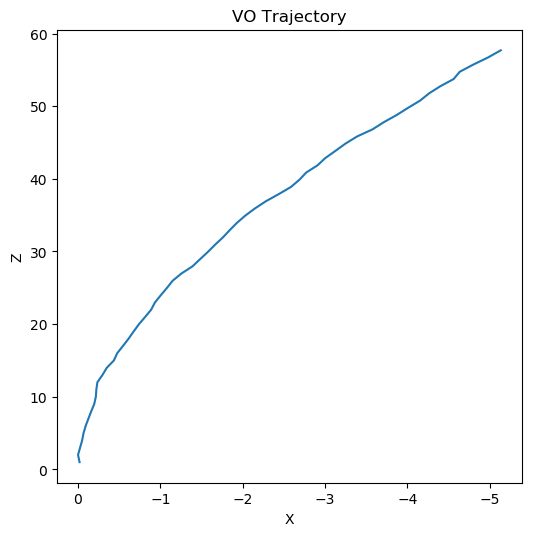

In [8]:

X = Robot(np.asarray(dataset.calib.K_cam0), minFeatures)
for i in range(len(dataset_gray) - 50):
    frame1 = np.asarray(dataset_gray[i][0])
    frame2 = np.asarray(dataset_gray[i+1][0])
    
    r, t = X.process_features(frame1, frame2, np.asarray(dataset.calib.K_cam0))
    
    X.pose_calc(r,t)
    
    # uncomment to visualise sift feature matches
    #X.sift_visualize(frame1,frame2)

    
X.plot_trajectory()    
cv2.destroyAllWindows()    